In [27]:
import ROOT as r
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline

In [28]:
'''
Returns the time vs. x and time vs. y data from the pixel_hits. The ATAR is made up of sheets that contain alternating horizontal or vertical strips with npixels_per_plane.
If npixels_per_plane were 100, for instance, 100036 would represent plate 1, 36 / 100 in x, 100161 would represent plate 2, 61 / 100 in y, etc. The output for each of 
x and y is an n x 2 matrix, where the first column contains the times corresponding to the coordinate values in the second column.
Also extract the z (plane #) vs. time data. The third element of the tuples contained in this list and the x and y lists will contain corresponding colors to represent
when particles have decayed.

If is_event_DAR is "True," gather data for decays at rest; otherwise, only look at decays in flight.

last_entry allows us to start where we left off in the tree last time in the case where we display multiple events. If this is the first time we call this function, last_entry 
should be -1 in order to start from 0 the first time).

event_count = 0
     and event_count < num_events:            event_count += 1
'''
def get_event(tree, is_event_DAR, last_entry):
    #TODO Remove from this --> break statement and pass only (tree, event number i) to this function. Use another function to loop over all DARs / DIFs, with conds., etc. (see Slack)
    #Iterate across data in the tree starting from the entry immediately following the one at which we stopped last time.
    for i in range(last_entry + 1, tree.GetEntries()): #, e in [tree_list[j] for j in
        #print(str(e.pion_decay) + str(e.pion_decay))
        tree.GetEntry(i)
        
        if tree.pion_decay == 1 and tree.pion_dar == is_event_DAR:
            print("Index of event in tree: " + str(i))
            last_entry = i
            break
    
    #Store pixel hits for the entry printed above in which a pion didn't decay at rest.
    pixel_times = tree.pixel_time
    pixel_hits = tree.pixel_hits
    pixel_pdg = tree.pixel_pdg
    pixel_edep = tree.pixel_edep
    
    #TODO Pass x, y, z, t, E data individually to avoid redundancy.
    #Initialize lists for storing color (for labeling data points according to decay product), x, y, z, and energy.
    npixels_per_plane = 100
    c_data = t_data = x_data = y_data = z_data = E_data = []
    #For storing sum of energies deposited in each plane (data should show to < 50 planes deep in ATAR).
    E_per_plane = np.zeros(50)

    #Extract x vs. t, y vs. t, and z vs. t data. Also add indexed color coding to represent different particles.
    for i in range(pixel_hits.size()):
        plane = int(np.floor((pixel_hits[i] - 1 - 100_000) / npixels_per_plane))

        cur_val = (pixel_hits[i] - 1) % npixels_per_plane
        cur_time = pixel_times[i]

        if pixel_pdg[i] == 211:
            cur_color = "r"     # +Pion
        elif pixel_pdg[i] == -11:
            cur_color = "b"     # Positron
        elif pixel_pdg[i] == 11:
            cur_color = "g"     # Electron
        elif pixel_pdg[i] == -13:
            cur_color = "y"     # +Muon
        elif pixel_pdg[i] == 13:
            cur_color = "p"     # -Muon

        c_data.append(cur_color)
        t_data.append(cur_time)

        if(plane % 2 == 0):
            x_data.append(cur_val)
        else:
            y_data.append(cur_val)

        z_data.append(plane)
        E_data.append(pixel_edep[i])
        #Store sum of energies deposited in each plane.
        E_per_plane[plane] += pixel_edep[i]
    
    return (c_data, t_data, x_data, y_data, z_data, E_data, E_per_plane, last_entry)

In [29]:
#Show some useful parameters describing our event.
def display_event(c_data, t_data, x_data, y_data, z_data, E_data, E_per_plane):
    print("Length of t_data: " + str(len(t_data)))
    print("Length of x_data: " + str(len(x_data)))
    print("Length of y_data: " + str(len(y_data)))
    print("Length of z_data: " + str(len(z_data)))
    print("Length of E_data: " + str(len(E_data)))
    print("Length of E_per_plane: " + str(len(E_per_plane)))
    print("c_data: " + str(c_data))
    print("x_data: " + str(x_data))
    print("E_data: " + str(E_data))

In [30]:
#For each color in a list of color labels for different particles, plot the corresponding data.
def plot_with_color_legend(x_coords, y_coords, colors):
    for color in ["r", "b", "g", "y", "p"]:
        #Include only points of the current color / particle type each loop. This makes it easier to configure the legend.
        curpoints = []
        for i in range(len(colors)):
            if colors[i] == color:
                curpoints.append((x_coords[i], y_coords[i], colors[i]))
        
        #Only plot if the current particle decay type was present in the data.
        if len(curpoints) != 0:
            if color == "r":
                plt.scatter([i[0] for i in curpoints], [i[1] for i in curpoints], 10, [i[2] for i in curpoints], label = "Pion")
            elif color == "b":
                plt.scatter([i[0] for i in curpoints], [i[1] for i in curpoints], 10, [i[2] for i in curpoints], label = "Positron")
            elif color == "g":
                plt.scatter([i[0] for i in curpoints], [i[1] for i in curpoints], 10, [i[2] for i in curpoints], label = "Electron")
            elif color == "y":
                plt.scatter([i[0] for i in curpoints], [i[1] for i in curpoints], 10, [i[2] for i in curpoints], label = "Antimuon")
            elif color == "p":
                plt.scatter([i[0] for i in curpoints], [i[1] for i in curpoints], 10, [i[2] for i in curpoints], label = "Muon")


#Plot x vs. t, y vs. t, z vs. t, and E vs. z data from our event. The graphs will show the color-coding system used to represent different particles.
#Display 0 to num_planes on plots including the z variable.
def plot_event(c_data, t_data, x_data, y_data, z_data, E_data, E_per_plane, num_planes):

    plt.figure(figsize = (24, 5))

    plt.subplot(1,4,1)
    plot_with_color_legend(z_data, x_data, c_data)
    plt.title("x vs. z")
    plt.xlabel("z (plane number)")
    plt.ylabel("x (pix)")
    plt.legend()
    plt.xlim(0, num_planes)
    plt.ylim(0, 100)

    plt.subplot(1,4,2)
    plot_with_color_legend(z_data, y_data, c_data)
    plt.title("y vs. z")
    plt.xlabel("z (plane number)")
    plt.ylabel("y (pix)")
    plt.xlim(0, num_planes)
    plt.ylim(0, 100)

    plt.subplot(1,4,3)
    plot_with_color_legend(t_data, z_data, c_data)
    plt.title("z vs. t")
    plt.xlabel("t (ns)")
    plt.ylabel("z (plane number)")
    plt.ylim(0, num_planes)

    plt.subplot(1,4,4)
    plt.scatter(z_data, E_data, 10)
    plt.title("ATAR Energy Deposition Per Plane vs. z")
    plt.xlabel("z (plane number)")
    plt.ylabel("Energy (MeV / plane)")
    #plt.xlim(0, num_planes)

    plt.subplots_adjust(left = 0.1,
                        bottom = 0.1, 
                        right = 0.9, 
                        top = 0.9, 
                        wspace = 0.5, 
                        hspace = 0.4)

In [31]:
#Combines the functions we created above to give a visualization of events with the specified condition(s).
#is_event_DAR = True / False controls whether we should view DARs / DIFs.
#display_text_output = True / False controls whether we should have text info / not have text info displayed.
#num_events allows us to plot multiple events with the specified conditions from the tree.
def event_visualization(tree, is_event_DAR, display_text_output, num_events):
    #Ensure we start at the -1 + 1 = 0th entry in the tree.
    last_entry = -1
    
    for i in range(num_events):
        #TODO Move E_per_plane summation here.
        c_data, t_data, x_data, y_data, z_data, E_data, E_per_plane, last_entry = get_event(tree, is_event_DAR, last_entry)
        
        if display_text_output:
            display_event(c_data, t_data, x_data, y_data, z_data, E_data, E_per_plane)

        plot_event(c_data, t_data, x_data, y_data, z_data, E_data, E_per_plane, 40)

Index of event in tree: 0


TypeError: 'value' must be an instance of str or bytes, not a float

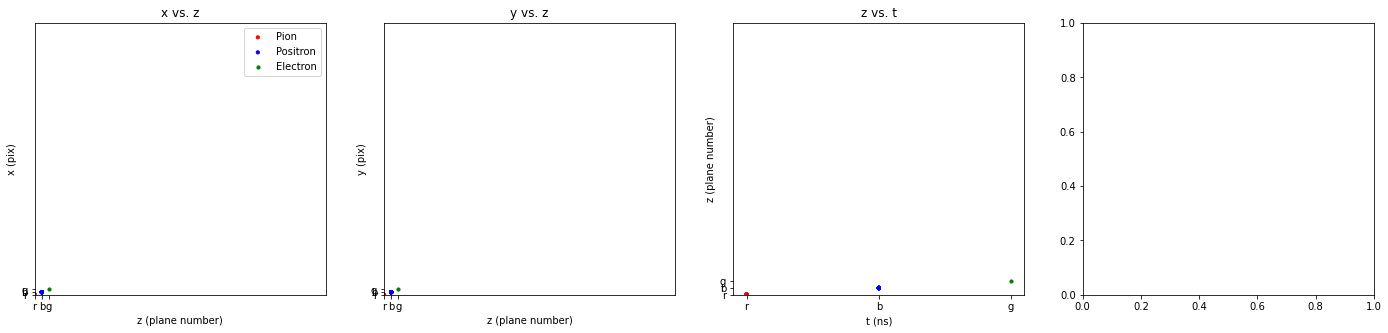

In [32]:
#Explore pion --> e data.
f = r.TFile("pienux_out_stripped.root")
tree = f.Get("atar")
# print([x.GetName() for x in t.GetListOfBranches()])
# print("\n")

event_visualization(tree, True, False, 2)

Index of event in tree: 0
Index of event in tree: 2


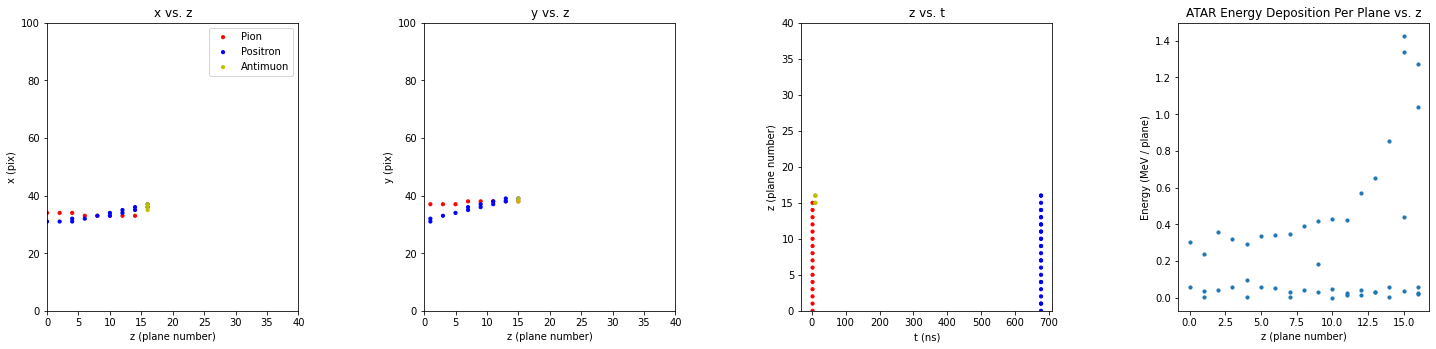

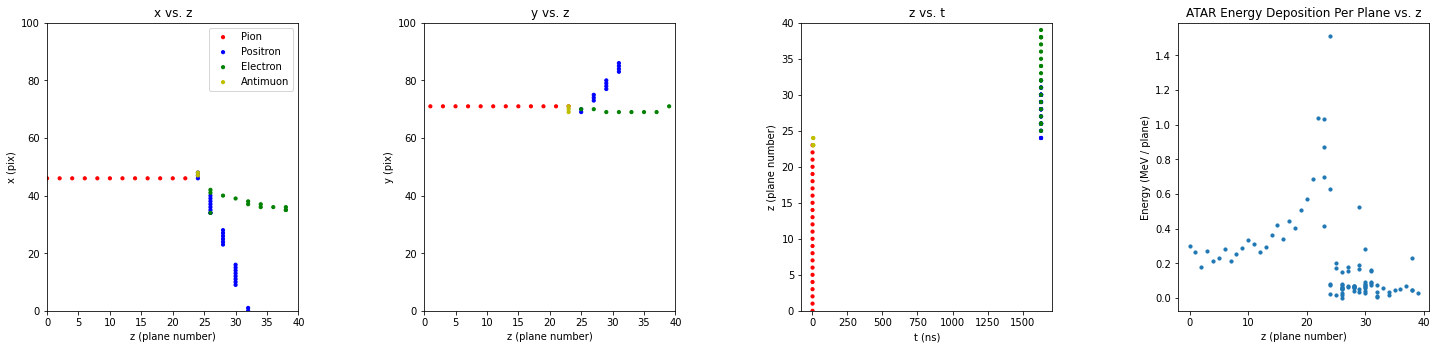

In [ ]:
#Explore pion --> muon --> e data.
f = r.TFile("pienux_out_stripped_muons.root")
tree = f.Get("atar")

event_visualization(tree, True, False, 2)